<a href="https://colab.research.google.com/github/M-torki/C-S-NN/blob/master/noise_free_FFP10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 1.x

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
cd /gdrive/My\ Drive/

/gdrive/My Drive


In [5]:
!pip install git+https://github.com/vafaei-ar/ccgpack.git

  Cloning https://github.com/vafaei-ar/ccgpack.git to /tmp/pip-req-build-uld18eu7
  Running command git clone -q https://github.com/vafaei-ar/ccgpack.git /tmp/pip-req-build-uld18eu7
  Created wheel for ccgpack: filename=ccgpack-0.1.0-cp37-cp37m-linux_x86_64.whl size=910057 sha256=33dbd5080e450b2993d926eac1c8c00301d791d627bd5e3ec10a3e34ecf3d64b
  Stored in directory: /tmp/pip-ephem-wheel-cache-zut5r0wa/wheels/a8/3c/86/3720d002b7c606972520b7468f7b9daf3da3acc3052facac45
Successfully built ccgpack


In [6]:
!pip install git+https://github.com/vafaei-ar/Ngene.git

  Cloning https://github.com/vafaei-ar/Ngene.git to /tmp/pip-req-build-c4mijchy
  Running command git clone -q https://github.com/vafaei-ar/Ngene.git /tmp/pip-req-build-c4mijchy
  Created wheel for ngene: filename=ngene-0.1.0-cp37-none-any.whl size=11659 sha256=506c4c3133e42c2c420fd3d03993c0e4c2e1f6174a4fc884fe56b0cda69e68fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-4btw3prp/wheels/f7/d2/a8/1dae975d187b4a9790d83da45caaef0d018b41ffc0ab7fceb7
Successfully built ngene


In [8]:
import sys
sys.path.append('/gdrive/My\ Drive/git_reps/ccgpack')
sys.path.append('/gdrive/My\ Drive/git_reps/Ngene')

In [9]:
import os
import ngene as ng
import numpy as np
import pylab as plt
from glob import glob
import tensorflow as tf
from random import choice,shuffle
import cv2 as cv
# import healpy as hp

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
def conf_plotter(y_true, y_pred, classes,
                      normalize=0,
                      title=None,
                      cmap=plt.cm.pink_r,
                      mode = 'train',
                      save = 0,
                      name = 'conf.jpg'):

    if not title:
        if mode == 'train':
            title = 'Normalized confusion matrix on train dataset'
        if mode == 'test':
            title = 'Normalized confusion matrix on test dataset'
        if mode == 'prob':
            title = 'Normalized confusion matrix on Non-Overlapping test dataset'
            

    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(cm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax ,fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[1]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel= 'True label',
           xlabel='Predicted label')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ):
                    
        item.set_fontsize(15)
     
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        
        item.set_fontsize(12)

                
    plt.gca().invert_yaxis()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save == 1:
        plt.savefig(name)
    return ax

In [11]:
(np.load('./data/test/string_p/24.npy')).std()

14.9875145

In [12]:
(np.load('./data/ffp10_p/401.npy')).std()

0.00010234469

In [13]:
def get_slice(data,nx,ny):
    """Slice matrix in x and y direction"""
    lx,ly = data.shape  
    if nx==0 or nx==lx:
        slx = slice(0, lx)                
    else:
        idx = np.random.randint(0, lx - nx)            
        slx = slice(idx, (idx+nx))       
    if ny==0 or ny==ly:
        sly = slice(0, ly)                
    else:
        idy = np.random.randint(0, ly - ny)            
        sly = slice(idy, (idy+ny))
    return slx, sly

In [14]:

class OrganizedDataProvider(object):
    def __init__(self,n_files,s_files,gmus,
                 nx=0,ny=0,n_buffer=10,
                 reload_rate=100,filt=None , test=0):

        self.n_files = n_files
        self.s_files = s_files
        self.test = test

        nmin = min(len(n_files),len(s_files))
        if n_buffer>= nmin:
            n_buffer = nmin
            self.reload_rate = 0
        else:
            self.reload_rate = reload_rate

        self.nx,self.ny = nx,ny
        self.n_buffer = n_buffer
        self.gmus = gmus
        if filt is None:
            def filt(x):
                return x
        self.filt = filt
        self.counter = 0
        self.reload()

    def reload(self):
        print('Data provider is reloading...')
        self.n_set = []
        self.s_set = []
    #        self.d_set = []
        nind = np.random.randint(0,len(self.n_files))
        
        if self.test:
            sind = (nind%12)
        else:

            sind = np.random.randint(1,3)
            if sind==1:
                sind = (nind%12)
            elif sind==2:
                sind = (nind%12)+12
            
#         print('sind' , sind , 'nind' , nind)



    #        ninds = np.arange(len(self.n_files))
    #        sinds = np.arange(len(self.s_files))
    #        shuffle(ninds)
    #        shuffle(sinds)
        for i in range(self.n_buffer):
            filen = self.n_files[nind]
            files = self.s_files[sind]
            self.n_set.append(np.load(filen))
            signal = np.load(files)
            self.s_set.append(signal)
    #            if self.filt:
    #                self.d_set.append(self.filt(signal))
    #            else:
    #                self.d_set.append(signal)
    #            

    def get_data(self): 
        self.counter += 1
        if self.reload_rate:
            if self.counter%self.reload_rate==0: 
                self.reload() 
    #        n = choice(self.n_set)
        ind = choice(np.arange(self.n_buffer))
        s = self.s_set[ind]
        n = self.n_set[ind]
#         print('ind' , ind)


    #        d = self.d_set[sind]
        return n,s#,d


    def pre_process(self, n, s, gmu):
        sn = n + gmu*s
        snslice = get_slice(sn,self.nx,self.ny)
        sn = sn[snslice]
        #        sslice = get_slice(s,self.nx,self.ny)
        #        s = s[sslice]
        # sn = self.filt(sn)
        sn = cv.bilateralFilter(sn,5,1e-3,1e-3)
        # sn = self.filt(sn)

        #        d = d[sslice]
        sn = np.expand_dims(sn,-1)
        #        d = np.expand_dims(d,-1)
        return sn#,d

    def __call__(self, n, gmus=None): 

        if gmus is None:
            gmus = self.gmus
        n_class = len(gmus)
        #        x,y = self.get_data()
        X = []
        Y = []
        for i in range(n):                
            n,s = self.get_data()
            inds = np.arange(n_class)
            shuffle(inds)
            gmu = gmus[inds[0]]
            #            gmu = choice(gmus)
            sn = self.pre_process(n,s,gmu)
            #            rand = np.random.randint(0,2)
            #            sn = sn-sn+rand

#             sn = (sn - np.min(sn))/(np.max(sn) - np.min(sn))

            sn = (sn - np.mean(sn))/(np.std(sn) + 1e-30)


            X.append(sn)
            #            Y.append(-np.log10(gmu+1e-30))
            lbl = n_class*[0]
            lbl[inds[0]] = 1
            Y.append(lbl)



        X = np.array(X)
        Y = np.array(Y)

        return X,Y

In [15]:
gmus = [0]+list(5* 10**np.linspace(-8 , -5 , 10))
n_class = len(gmus)
print(gmus)

[0, 5e-08, 1.0772173450159411e-07, 2.320794416806391e-07, 5e-07, 1.0772173450159411e-06, 2.3207944168063863e-06, 4.9999999999999996e-06, 1.0772173450159412e-05, 2.3207944168063865e-05, 5e-05]


In [16]:
dofilt = 'y'

if dofilt[0]=='y':
    import ccgpack as ccg
    def filt(x):
        return ccg.filters(x,edd_method='sch')
else:
    filt = None

In [17]:
g_files = sorted(glob('./data/ffp10_p/*.npy'))
s_files = sorted(glob('./data/string_p/*.npy'))

if len(g_files)*len(s_files)==0:
    print('Somthing is wrong with initiation.')
    #exit()
print(len(g_files),len(s_files))

480 24


In [18]:
g_test = sorted(glob('./data/test/ffp/ffp_ptest/*.npy'))
s_test = sorted(glob('./data/test/string_p/*.npy'))

# s_test = s_files

if len(g_test)*len(s_test)==0:
    print('Somthing is wrong with initiation.')
#     exit()
    
print(len(g_test) , len(s_test))

99 12


In [19]:
odp = OrganizedDataProvider(g_files,s_files,
                              gmus=gmus,
                              nx=256,ny=256,n_buffer=10,
                              reload_rate=1e5,filt=filt,test=0)

Data provider is reloading...


In [20]:
odp_test = OrganizedDataProvider(g_test,s_test,
                                 gmus=gmus,
                                 nx=256,ny=256,n_buffer=10,
                                 reload_rate=1e5,filt=filt,test=1)

Data provider is reloading...


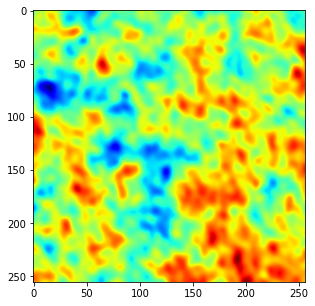

In [21]:
plt.figure(figsize = (5,5))
plt.imshow(odp(1)[0][0,:,:,0] , cmap='jet')

In [22]:
def arch_maker(x,n_conv,n_class):

    print("\033[91m ============================= Begin ========================= \033[0m")
    
    for _ in range(4):

        
        x = tf.layers.conv2d(x,filters=4,kernel_size=5,
                              strides=(1, 1),padding='same')
        print(x)
        x = tf.layers.batch_normalization(x)
        print(x)
        x = tf.nn.crelu(x)
        print(x)

    for _ in range(n_conv):

        x = tf.layers.conv2d(x,filters=8,kernel_size=5,
                              strides=(1, 1),padding='same')
        print(x)
        x = tf.layers.batch_normalization(x)
        print(x)
        x = tf.nn.crelu(x)
        print(x)

        x = tf.layers.conv2d(x,filters=16,kernel_size=5,
                              strides=(2, 2),padding='same')
        print(x)
        x = tf.layers.batch_normalization(x)
        print(x)
        x = tf.nn.crelu(x)
        print(x)
        x = tf.layers.max_pooling2d(x,pool_size=2,strides=1)
        print(x)


    x = tf.contrib.layers.flatten(x)
    print(x)
    x = tf.nn.dropout( x, keep_prob=0.5)
    print(x)
    x = tf.layers.dense(x, 20 , activation=tf.nn.crelu)
    print(x)
    x = tf.nn.dropout( x, keep_prob=0.5)
    print(x)
    y = tf.layers.dense(x, n_class, activation=tf.nn.softmax)
    print(y)

    print("\033[91m ============================ END ============================= \033[0m")

    return y

In [23]:
restore = os.path.isdir('./models/model_noisefree_FFP')
restore = 1

In [24]:
def arch(x):
    return arch_maker(x,6,n_class)    

In [25]:
def loss(y_true,x_out):
    return tf.losses.huber_loss(y_true,x_out)  

In [26]:
conv = ng.Model(data_provider= odp,
                 optimizer=tf.train.AdamOptimizer,
                 loss = loss,
                 restore=restore,
                 model_add= './models/model_noisefree_FFP',
                 arch=arch)

 ============================= Begin ========================= 
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Tensor("conv2d/BiasAdd:0", shape=(?, 256, 256, 4), dtype=float32)
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Tensor("batch_normalization/FusedBatchNormV3:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("CRelu/Relu:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("conv2d_1/BiasAdd:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("batch_normalization_1/FusedBatchNormV3:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("CRelu_1/Relu:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("conv2d_2/BiasAdd:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("batch_normalization_2/FusedBatchNormV3:0", shape=(?, 256, 256

In [ ]:
# conv.train(data_provider=odp,training_epochs=100000, 
#             iterations=100, n_s=120,
#             learning_rate = 0.001, verbose=1 , time_limit = 20)

# Y_t  = [] 
# pr_t = []

# for _ in range(500):
#     x,y = odp_test(1)
#     pred = conv.predict(x)
#     Y_t.append(np.argmax(y))
#     pr_t.append(np.argmax(pred))
    
# conf_plotter(Y_t , pr_t , labels , normalize=1, cmap = plt.cm.gnuplot_r ,mode='test', save=0 , name='overlapping_test.jpg')

#Correction of labels :

String simulated maps are delta(T)/T . CMB simulations are just delta(T)...
So we have to divide gaussian maps to T (ie. Sky temperature which is 2.7 kelvin)
We could do this in our data provider but there is no difference whether we divide Gaussian map to T or divide gmu value to it because at the end we multiply G maps by the gmu. So : 

In [28]:
gmus_ = [gmus[i]/2.7 for i in range(n_class)]
print(gmus_)   
labels = []
for gmu in gmus_:
    labels.append('{:3.1e}'.format(gmu)) 

[0.0, 1.8518518518518515e-08, 3.9896938704294115e-08, 8.595534877060707e-08, 1.8518518518518516e-07, 3.989693870429411e-07, 8.595534877060689e-07, 1.8518518518518517e-06, 3.989693870429411e-06, 8.59553487706069e-06, 1.8518518518518518e-05]


In [29]:
def get_slice_seq(data,nx,ny):
    cp = []
    for i in range(8):
        for j in range(8):          
            cp.append(data[i*nx:(i+1)*nx , j*ny:(j+1)*ny])
    cp = np.array(cp)
    return cp

In [38]:
class non_overlap_dp(object):
    def __init__(self,n_files,s_files,gmus,s2n=None,
                 nx=0,ny=0,n_buffer=10,
                 reload_rate=100,filt=None , test=0 , noisy=1):

        self.n_files = n_files
        self.s_files = s_files
        self.test = test
        self.noisy = noisy
        self.s2n = s2n

        nmin = min(len(n_files),len(s_files))
        if n_buffer>= nmin:
            n_buffer = nmin
            self.reload_rate = 0
        else:
            self.reload_rate = reload_rate

        self.nx,self.ny = nx,ny
        self.n_buffer = n_buffer
        self.gmus = gmus
        if filt is None:
            def filt(x):
                return x
        self.filt = filt
        self.counter = 0
        self.reload()

    def reload(self):
        print('Data provider is reloading...')
        self.n_set = []
        self.s_set = []
    #        self.d_set = []
        nind = np.random.randint(0,len(self.n_files))
        
        if self.test:
            sind = (nind%12)
        else:

            sind = np.random.randint(1,3)
            if sind==1:
                sind = (nind%12)
            elif sind==2:
                sind = (nind%12)+12
            
        for i in range(self.n_buffer):
            filen = self.n_files[nind]
            files = self.s_files[sind]
            self.n_set.append(np.load(filen))
            signal = np.load(files)
            self.s_set.append(signal)

    def get_data(self): 
        self.counter += 1
        if self.reload_rate:
            if self.counter%self.reload_rate==0: 
                self.reload() 
    #        n = choice(self.n_set)
        ind = choice(np.arange(self.n_buffer))
        s = self.s_set[ind]
        n = self.n_set[ind]

        return n,s

    
    def pre_process(self, n, s, gmu):
        
        sn = []
                    
        sky = n + gmu*(s)

        sky = cv.bilateralFilter(sky,5,1e-3,1e-3)

        snslice = get_slice_seq(sky,self.nx,self.ny)
        # print(snslice.shape)
        for i in range(len(snslice)):                    
            sn1 = snslice[i]
            sn1 = (sn1 - np.mean(sn1))/(np.std(sn1) + 1e-30)
            # print(sn1.shape)
            sn.append(sn1[:,:])

        sn = np.array(sn)
#         print(sn.shape)
            
        sn = np.expand_dims(sn,-1)

        return sn#,d

    def __call__(self, n, gmus=None): 

        if gmus is None:
            gmus = self.gmus
        n_class = len(gmus)
        #        x,y = self.get_data()
        X = []
        Y = []
        for i in range(n):                
            n,s = self.get_data()
            # print(n.shape)
            inds = np.arange(n_class)
            shuffle(inds)
            gmu = gmus[inds[0]]
            #            gmu = choice(gmus)
            sn  = self.pre_process(n,s,gmu)
            #            rand = np.random.randint(0,2)
            #            sn = sn-sn+rand

#             sn = (sn - np.min(sn))/(np.max(sn) - np.min(sn))

            #            Y.append(-np.log10(gmu+1e-30))

            lbl = n_class*[0]
            lbl[inds[0]] = 1
            Y.append(lbl)
            X.append(sn)

        X = np.array(X)
        Y = np.array(Y)

        return X,Y

In [39]:
nodp_test = non_overlap_dp(g_test,s_files,
                            gmus=gmus,
                            nx=256,ny=256,n_buffer=10,
                            reload_rate=1e5,filt=filt,test=1 , noisy=0)

Data provider is reloading...


(1, 64, 256, 256, 1) (1, 11)


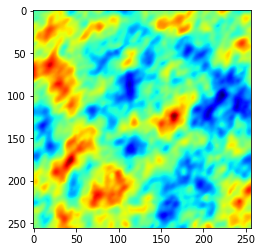

In [40]:
x,y=nodp_test(1)
print(x.shape , y.shape)
plt.imshow(x[0,0,:,:,0] , 'jet')

In [44]:
Xs = {
'x0' : [],
'x1' : [],
'x2' : [],
'x3' : [],
'x4' : [],
'x5' : [],
'x6' : [],
'x7' : [],
'x8' : [],
'x9' : [],
'x10' : []
}


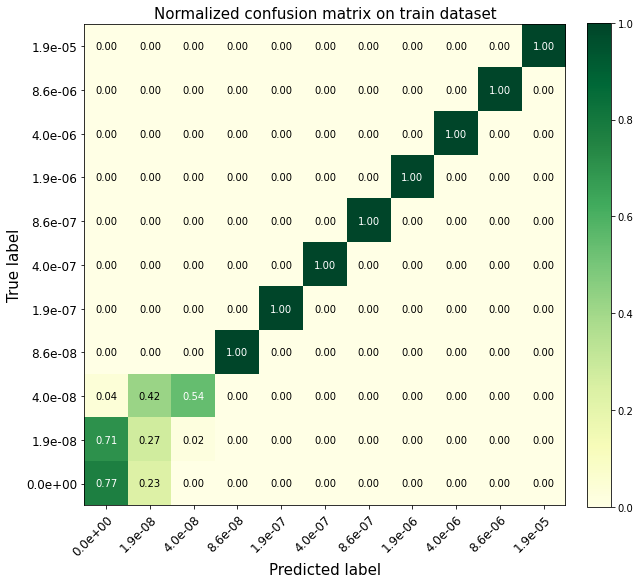

In [45]:
Y_t  = [] 
pr_t = []

for _ in range(500):
    
    x, y = nodp_test(1)
    b = 'x{}'.format(np.argmax(y))

    pred = []
    
    for i in range(6):
        pred.append(conv.predict(x[:,i,:,:,:]))
#     print(np.array(pred).shape)  

    preds = np.prod(np.vstack(pred), axis=0)
    preds = preds/(sum(preds)+1e-30)
#     print(preds)    

    (Xs[b]).append( float(np.dot(preds , gmus_)) ) 
# Xs
        
    Y_t.append(np.argmax(y))
    pr_t.append(np.argmax(preds))


conf_plotter(Y_t , pr_t , labels , normalize=1, cmap = plt.cm.YlGn ,
             title ='' , save=1 , name='Final CM_noisefree_ffp.png')

In [46]:
from scipy.stats import ttest_ind

dist_0 = Xs['x0']
pv_d = [1]

for i in range(1,n_class):
    dist = Xs['x{}'.format(i)]
    tt , pval = ttest_ind(dist , dist_0 )
    pv_d.append(pval)
    
    if pval<= 0.05:
        print('{:3.2e}'.format(gmus_[i]) , ':' , pval)
print('pv_det:' , pv_d)


from scipy.interpolate import interp1d

f = interp1d(pv_d[:6],gmus_[:6], kind='linear')
pv_det = f(0.05)
print('pv_det:' , pv_det)

3.99e-08 : 7.203061703842449e-19
8.60e-08 : 1.3463081826643575e-129
1.85e-07 : 7.01077916926613e-170
3.99e-07 : 5.98093929812437e-172
8.60e-07 : 1.7512086829458065e-224
1.85e-06 : 2.9633874302193804e-235
3.99e-06 : 2.753e-320
8.60e-06 : 4.755545885182521e-297
1.85e-05 : 0.0
pv_det: [1, 0.09026466675290906, 7.203061703842449e-19, 1.3463081826643575e-129, 7.01077916926613e-170, 5.98093929812437e-172, 1.7512086829458065e-224, 2.9633874302193804e-235, 2.753e-320, 4.755545885182521e-297, 0.0]
pv_det: 2.805486308665682e-08


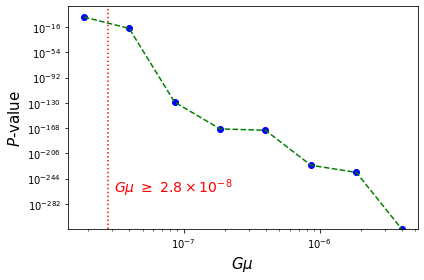

In [66]:
pv_d = [1, 0.09026466675290906, 7.203061703842449e-19, 1.3463081826643575e-129, 7.01077916926613e-170, 5.98093929812437e-172, 1.7512086829458065e-224, 2.9633874302193804e-235, 2.753e-320, 4.755545885182521e-297, 0.0]
plt.axes(xscale='log' , yscale='log')
plt.xlabel('$G\mu$' ,   fontsize=15)
plt.ylabel('$\it{P}$-value' , fontsize=15)
plt.plot(gmus_[1:-2] , pv_d[1:-2] , 'bo' , gmus_[1:-2] , pv_d[1:-2] , 'g--')
plt.axvline(2.8e-8, color='red', ls=':')#, label='$\it{P}$-value = 0.05' )

plt.text(3.1e-8, 1e-265 ,r'$G\mu$ $\geq$ $2.8\times 10^{-8}$' , color='r' ,fontsize=14)
plt.tight_layout()
plt.savefig('final_pv_noisefree_ffp.png')
plt.savefig('final_pv_noisefree_ffp.pdf')